In [1]:
%matplotlib inline

In [2]:
import numpy as np
import random  as rd
from numba import jit
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
import math
import random

In [51]:
G = 6.67408e-11 # m**3 kg**-1 s**-2 ----- Gravitational constant
nParticles = 250
nStars = 2
planetmass = 5.96e26
nt_simulation = 60

# =======================================================================
# -----------------------------Positions---------------------------------
# =======================================================================

if nStars == 1:
    init_particle_x = np.hstack(([0], (np.random.normal(0,1,nParticles))*1.5e12))
    init_particle_y = np.hstack(([0], (np.random.normal(0,1,nParticles))*1.5e12))
if nStars == 2:
    init_particle_x = np.hstack(([1.5e11*4], [-1.5e11*4],
                                 (np.random.normal(0,1,nParticles))*1.5e12*.5))
    init_particle_y = np.hstack(([0], [0], (np.random.normal(0,1,nParticles))*1.5e12*.5))

init_particle = np.vstack((init_particle_x,init_particle_y)).T
print "init_particle:\n", init_particle

particlem = np.hstack(([2e30]*nStars, [planetmass]*nParticles))
com = sum([particlem[j]*init_particle_x[j] for j in range(nParticles + nStars)]) / sum(particlem)

# =======================================================================
# ----------------------------Velocities---------------------------------
# =======================================================================

if nStars == 1:
    init_v_x_stars = [0]
    init_v_y_stars = [0]
    init_v_x_planets = [math.copysign(np.sqrt(G * particlem[0] /
                                              np.sqrt(init_particle_x[ii]**2 +
                                                      init_particle_y[ii]**2)) *
                                      np.cos(np.arctan2(init_particle_y[ii],init_particle_x[ii])+(np.pi/2.)),
                                     - init_particle_y[ii])
                        for ii in range(nStars,nStars+nParticles)]
    init_v_y_planets = [math.copysign(np.sqrt(G * particlem[0] /
                                              np.sqrt(init_particle_x[ii]**2 +
                                                      init_particle_y[ii]**2)) *
                                      np.sin(np.arctan2(init_particle_y[ii],init_particle_x[ii])+(np.pi/2.)),
                                     init_particle_x[ii])
                        for ii in range(nStars,nStars+nParticles)]
    init_v_x = init_v_x_stars + init_v_x_planets
    init_v_y = init_v_y_stars + init_v_y_planets
    init_v = np.vstack((init_v_x,init_v_y)).T

if nStars == 2:
    init_v_x_stars = [0 for i in range(nStars)]
    init_v_y_stars = [math.copysign(np.sqrt(G * particlem[0] / (abs(4*init_particle_x[ii]))), 
                              init_particle_x[ii]) for ii in range(nStars)]

    init_v_x_planets = [math.copysign(np.sqrt(G * (particlem[0]+particlem[1]) /
                                              np.sqrt(init_particle_x[ii]**2 +
                                                      init_particle_y[ii]**2)) *
                                      np.cos(np.arctan2(init_particle_y[ii],init_particle_x[ii])+(np.pi/2.)),
                                     - init_particle_y[ii])
                        for ii in range(nStars,nStars+nParticles)]
    init_v_y_planets = [math.copysign(np.sqrt(G * (particlem[0]+particlem[1]) /
                                              np.sqrt(init_particle_x[ii]**2 +
                                                      init_particle_y[ii]**2)) *
                                      np.sin(np.arctan2(init_particle_y[ii],init_particle_x[ii])+(np.pi/2.)),
                                     init_particle_x[ii])
                        for ii in range(nStars,nStars+nParticles)]
    init_v_x = init_v_x_stars + init_v_x_planets
    init_v_y = init_v_y_stars + init_v_y_planets
    init_v = np.vstack((init_v_x,init_v_y)).T

print "init_v:\n", init_v

#=======================================================================
#--------------------------------Forces---------------------------------
#=======================================================================

def galsim(particle, particlev, particlem, nParticles, nStars):
    dt= 5e5
    G = 6.67408e-11
    eps = 5e7
    for i in range(nParticles + nStars):
        Fx = 0.0
        Fy = 0.0
        for j in range(nParticles + nStars):
            if j != i:
                dx = particle[j,0] - particle[i,0]
                dy = particle[j,1] - particle[i,1]
                dr = np.sqrt(dx**2 + dy**2)
                F = - G * particlem[i] * particlem[j] / (dr+eps)**2
                Fx += (math.copysign(F * np.cos(np.arctan(dy / dx)), dx))
                Fy += (math.copysign(F * np.sin(np.arctan(dy / dx)), dy))
        particlev[i, 0] += ((Fx / particlem[i]) * dt)
        particlev[i, 1] += ((Fy / particlem[i]) * dt)
    for i in range(nParticles + nStars):
        particle[i,0] += (particlev[i,0] * dt)
        particle[i,1] += (particlev[i,1] * dt)
    return particle, particlev

# =======================================================================
# -----------------------------Execution---------------------------------
# =======================================================================

init_gal = galsim(init_particle, init_v, particlem, nParticles, nStars)
print "init:\n", init_gal[0]
#Initializing lists
states = []
x = []
y = []

#Creating lists of the X and Y coordinates of each particle from t=0 to t=nt_simulation
for t in range(nt_simulation):
    gal_data = galsim(init_gal[0],init_gal[1],particlem, nParticles, nStars)
    states.append(gal_data[0])
    current_state = states[t]
    current_copy_x = list(current_state[:,0])
    x.insert(t,current_copy_x)
    current_copy_y = list(current_state[:,1])
    y.insert(t,current_copy_y)
    init_gal = gal_data
    
# =======================================================================
# =======================================================================
# ------------------------------Animation--------------------------------
# =======================================================================
# =======================================================================

planetc1 = np.array([random.uniform(0, 1) for i in range(nParticles+nStars)])
planetc2 = np.array([random.uniform(0, 1) for i in range(nParticles+nStars)])
planetc3 = np.array([random.uniform(0, 1) for i in range(nParticles+nStars)])

def initial():
    particles.set_offsets([])
    return particles,

def animate(i):
    j = 0
    ntrails = 50
    data = np.vstack((x[i], y[i])).T
    while j < i and j < ntrails:
        data = np.vstack((data, np.vstack((x[i-j],y[i-j])).T))
        j += 1
    particles.set_offsets(data)
    
    percentm = np.array([(particlem[i] / sum(particlem)) for i in range(len(particlem))])
    percentm = percentm / percentm.max()*100
    percentm = (np.ceil(percentm)).tolist() * ntrails
    particles.set_sizes(percentm)
    
# =======================================================================
# -------------------------------Colors!---------------------------------
# =======================================================================
    
    from matplotlib import colors
    init_alpha = [[1.]*nStars+[1.]*nParticles][0]
    init_decay = []
    for decay in np.linspace(.25,0.0001,ntrails):
        init_decay += [[decay]*nStars + [decay]*nParticles][0]
    alpha = init_alpha + init_decay
    rgba_colors = np.zeros((len([[0]*nStars+[0]*nParticles][0]*(ntrails+1)),4))
    if nStars == 1:
        rgba_colors[::nParticles+nStars,0] = 240./255.
        rgba_colors[::nParticles+nStars,1] = 128./255.
        rgba_colors[::nParticles+nStars,2] = 128./255.
    if nStars == 2:
        for i in range(2):
            rgba_colors[i::nParticles+nStars,0] = 240./255.
            rgba_colors[i::nParticles+nStars,1] = 128./255.
            rgba_colors[i::nParticles+nStars,2] = 128./255.
    for i in range(nStars,nParticles+nStars):
        rgba_colors[i::nParticles+nStars,0] = planetc1[i]
        rgba_colors[i::nParticles+nStars,1] = planetc2[i]
        rgba_colors[i::nParticles+nStars,2] = planetc3[i]
    for a in range(len(alpha)):
        rgba_colors[a, 3] = alpha[a]
    particles.set_color(rgba_colors)

    return particles,

print "It begins!"

# fig = plt.figure(figsize=(12,12))
# fsize = 5e12
# ax = plt.axes(xlim=(-fsize, fsize), ylim=(-fsize, fsize))
# ax.set_facecolor('whitesmoke')
# ax.minorticks_on()
# ax.tick_params('both', length=8, which='major')
# ax.tick_params('both',length=3, which='minor')
# ax.set_xlabel('')
# ax.set_ylabel('')
# ax.xaxis.set_ticks_position('none')
# ax.yaxis.set_ticks_position('none')
# ax.set_xticklabels([])
# ax.set_yticklabels([])
# ax.grid(True, which='major', ls='dashed', alpha=.5)
# ax.grid(True, which='minor', ls='dashed', alpha=.15)
# particles = ax.scatter([], [], marker='o')
# plt.title('Simulation')

# rc('animation', html='html5')
# anim = animation.FuncAnimation(fig, animate, init_func = initial,
#                                frames=nt_simulation, interval=60, blit=True)
# anim

init_particle:
[[  6.00000000e+11   0.00000000e+00]
 [ -6.00000000e+11   0.00000000e+00]
 [  1.15268435e+11  -3.53123578e+11]
 [  2.50694398e+11  -1.19807130e+12]
 [ -2.77329163e+11  -4.90872314e+11]
 [ -4.78267298e+10   7.45430918e+11]
 [ -1.07143362e+12  -8.50970016e+11]
 [  1.20815236e+12   1.38677226e+12]
 [  7.58415157e+11   5.85563511e+11]
 [ -1.17749823e+12   1.75184286e+10]
 [ -6.40673169e+11  -4.35197080e+11]
 [  1.10981648e+12  -7.82784293e+11]
 [  9.29577205e+11  -8.46696615e+11]
 [ -1.17204670e+11  -5.08659392e+11]
 [  2.53229435e+11   1.07893324e+12]
 [ -3.18060648e+11   3.81968896e+11]
 [  5.45776693e+11   6.26422050e+11]
 [  1.47170322e+11   7.17798464e+10]
 [  1.76432857e+11   5.81686785e+11]
 [ -5.76018048e+11  -2.66412425e+11]
 [  2.54575791e+10   1.51835472e+12]
 [ -6.22255738e+10   1.53561422e+11]
 [  5.30251130e+11   1.71203563e+11]
 [  5.26957778e+11   1.12125079e+12]
 [  5.90873194e+11   1.04384687e+12]
 [ -6.83516895e+11  -7.84462683e+11]
 [  2.85843515e+11   2.

init:
[[  5.99975813e+11   3.72232430e+09]
 [ -5.99973927e+11  -3.73012919e+09]
 [  1.28040454e+11  -3.48885859e+11]
 [  2.57918611e+11  -1.19652474e+12]
 [ -2.67856909e+11  -4.96108157e+11]
 [ -5.72637927e+10   7.44772268e+11]
 [ -1.06706365e+12  -8.56402593e+11]
 [  1.20359844e+12   1.39071037e+12]
 [  7.53275556e+11   5.92076698e+11]
 [ -1.17749817e+12   9.98725140e+09]
 [ -6.35419614e+11  -4.42691607e+11]
 [  1.11382723e+12  -7.77019201e+11]
 [  9.34458231e+11  -8.41266118e+11]
 [ -1.06195600e+11  -5.11123408e+11]
 [  2.45671428e+11   1.08066625e+12]
 [ -3.27022818e+11   3.74419843e+11]
 [  5.39013163e+11   6.32215094e+11]
 [  1.38417096e+11   8.98970071e+10]
 [  1.66416789e+11   5.84660957e+11]
 [ -5.71725270e+11  -2.75258205e+11]
 [  1.88288111e+10   1.51844142e+12]
 [ -8.08580185e+10   1.45969595e+11]
 [  5.27230325e+11   1.80710193e+11]
 [  5.20308356e+11   1.12433477e+12]
 [  5.84371966e+11   1.04748136e+12]
 [ -6.77459316e+11  -7.89661615e+11]
 [  2.77140741e+11   2.68583295e

It begins!


In [41]:
from astropy.convolution import convolve, convolve_fft, Gaussian2DKernel

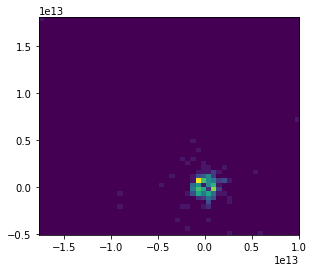

In [54]:
fig = plt.figure()
fsize = 5e11
kernel = Gaussian2DKernel(stddev=(50))
ax = plt.axes(xlim=(-fsize, fsize), ylim=(-fsize, fsize))
hh, xx, yy, pp = plt.hist2d(x[0], y[0], bins=50)
hh = convolve_fft(hh, kernel)
im=plt.imshow(a,interpolation="none", origin="lower",
              extent=[-fsize, fsize, -fsize, fsize])

def init():
    hh, xx, yy, pp = plt.hist2d(x[0],y[0],bins=50)
    hh = convolve_fft(hh, kernel)
    im.set_data(hh)
    return [im]

def animate(i):
    hh, xx, yy, pp = plt.hist2d(x[i],y[i],bins=50)
    hh = convolve_fft(hh, kernel)
    im.set_data(hh)
    return [im]

#fig = plt.figure(figsize=(8,8))
# fsize = 5e12
# ax = plt.axes(xlim=(-fsize, fsize), ylim=(-fsize, fsize))
# ax.set_facecolor('whitesmoke')
# ax.minorticks_on()
# ax.tick_params('both', length=8, which='major')
# ax.tick_params('both',length=3, which='minor')
# ax.set_xlabel('')
# ax.set_ylabel('')
# ax.xaxis.set_ticks_position('none')
# ax.yaxis.set_ticks_position('none')
# ax.set_xticklabels([])
# ax.set_yticklabels([])
# ax.grid(True, which='major', ls='dashed', alpha=.5)
# ax.grid(True, which='minor', ls='dashed', alpha=.15)
#ax.imshow(a,interpolation='gaussian')
rc('animation', html='html5')
anim = animation.FuncAnimation(fig, animate, init_func = init,
                               frames=nt_simulation, interval=60, blit=True)
anim

(array([[ 0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  1.,  1.,  1.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  2.,  4.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  2.,  0.,  0.,  3.,  3.,  0.,  1.,  0.],
       [ 0.,  0.,  1.,  0.,  1.,  3.,  1.,  0.,  1.,  1.],
       [ 1.,  1.,  1.,  0.,  1.,  0.,  1.,  2.,  0.,  0.],
       [ 0.,  1.,  1.,  2.,  1.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]]), array([ -1.56450883e+12,  -1.25865681e+12,  -9.52804782e+11,
        -6.46952758e+11,  -3.41100734e+11,  -3.52487098e+10,
         2.70603314e+11,   5.76455339e+11,   8.82307363e+11,
         1.18815939e+12,   1.49401141e+12]), array([ -1.39275058e+12,  -1.04128623e+12,  -6.89821880e+11,
        -3.38357529e+11,   1.31068218e+10,   3.64571173e+11,
         7.16035523e+11,   1.06749987e+12,   1.41896422e+

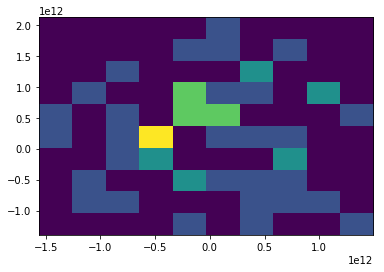

In [40]:
print plt.hist2d(x[10],y[10])

In [4]:
FFwriter = animation.FFMpegWriter()
anim.save('101bodies.mp4')

In [10]:
thing = np.array([1,2,3,4,5])
thing = np.array([np.vstack(i for i in thing)][0])
print thing

[[1]
 [2]
 [3]
 [4]
 [5]]
